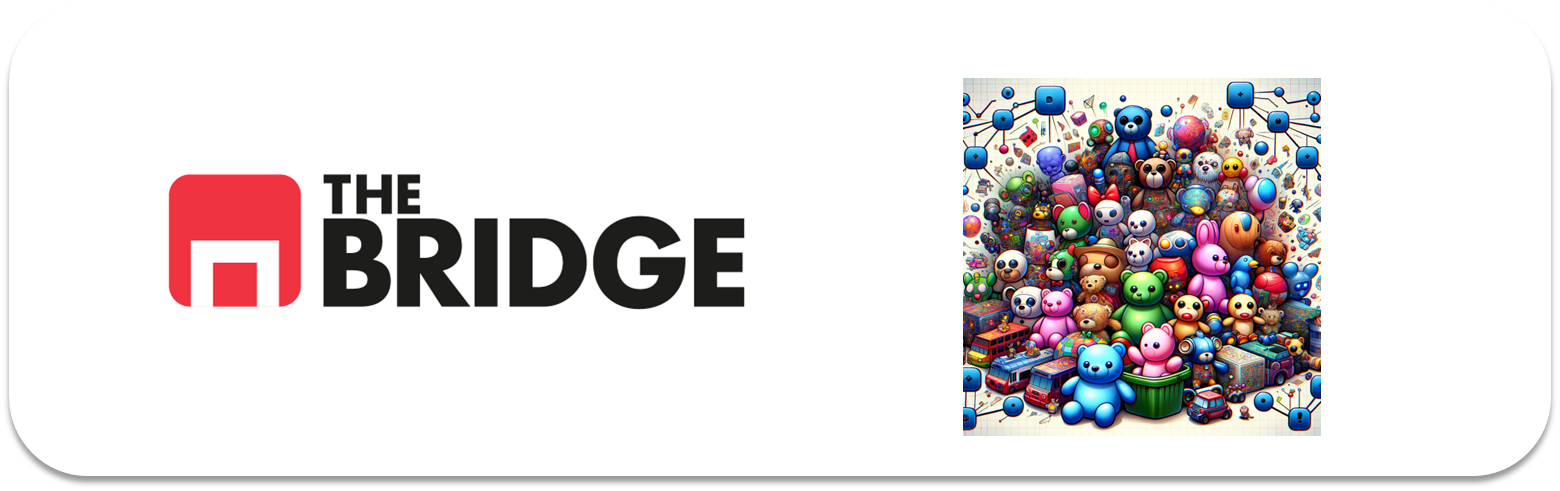

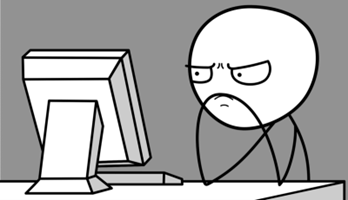

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [19]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import LabelEncoder, StandardScaler


### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [5]:
df = pd.read_csv("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ONLINE_DS_THEBRIDGE_ALVAROSMMS/Sprint_13/Unidad_01/Ejercicios_Workout/data/drugLibTrain_raw.tsv", sep="\t")

df.head()


,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [6]:
missing_values = df.isnull().sum()/len(df)*100
cardinality = df.nunique()

eda_summery = pd.DataFrame({
    "Unique Values": cardinality,
    "Missing values (%)": missing_values,
    }).sort_values(by="Unique Values", ascending=False)

eda_summery

    

,Unique Values,Missing values (%)
Unnamed: 0,3107,0.000000
commentsReview,3046,0.386225
benefitsReview,3031,0.579337
sideEffectsReview,2813,2.413904
condition,1426,0.032185
urlDrugName,502,0.000000
rating,10,0.000000
effectiveness,5,0.000000
sideEffects,5,0.000000


In [7]:
# Eliminar columnas innecesarias
columns_to_drop = ["Unnamed: 0", "urlDrugName", "benefitsReview", "sideEffectsReview", "commentsReview"]
df_cleaned = df.drop(columns=columns_to_drop)



### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [8]:
# Definir el train set X con las variables seleccionadas
X = df_cleaned.copy()

### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [13]:
# Copiar el dataset para transformación
X_transformed = X.copy()

# Transformar variables categóricas en valores numéricos
label_encoders = {}
categorical_columns = ["effectiveness", "sideEffects", "condition"]

for col in categorical_columns:
    le = LabelEncoder()
    X_transformed[col] = le.fit_transform(X_transformed[col])
    label_encoders[col] = le  # Guardar el encoder para posible interpretación futura

# Escalar la variable numérica `rating`
scaler = StandardScaler()
X_transformed["rating"] = scaler.fit_transform(X_transformed[["rating"]])

X_transformed


,rating,effectiveness,sideEffects,condition
0,-1.023494,1,1,797
1,-2.044907,1,4,224
2,1.019330,1,3,819
3,-1.363965,3,1,11
4,-1.704436,3,4,492
...,...,...,...,...
3102,1.019330,1,1,48
3103,-2.044907,2,0,369
3104,-1.704436,3,2,1365
3105,0.338389,0,1,450


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

<Figure size 1200x1000 with 0 Axes>

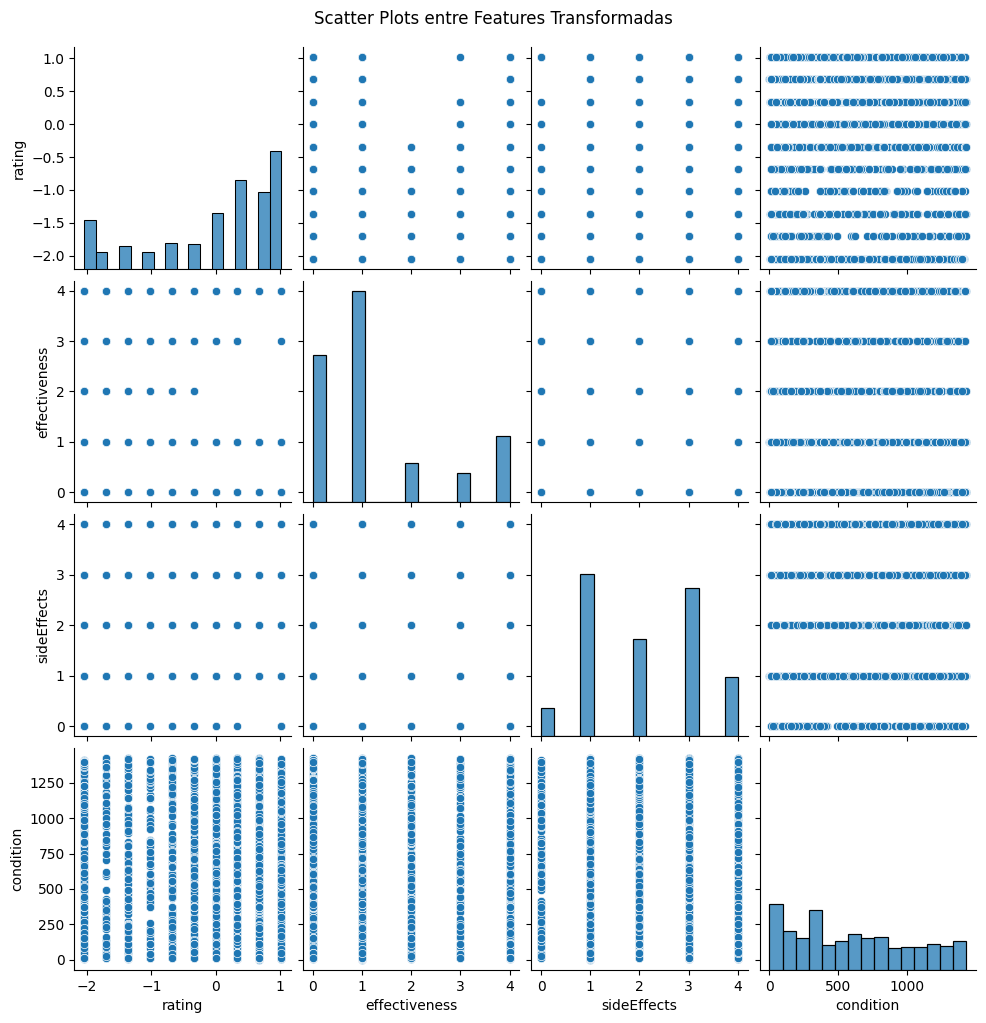

In [14]:
# Crear scatter plots para analizar la relación entre las features
plt.figure(figsize=(12, 10))

# Pairplot para ver posibles agrupaciones
sns.pairplot(X_transformed, diag_kind="hist")
plt.suptitle("Scatter Plots entre Features Transformadas", y=1.02)

# Mostrar gráfico
plt.show()

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

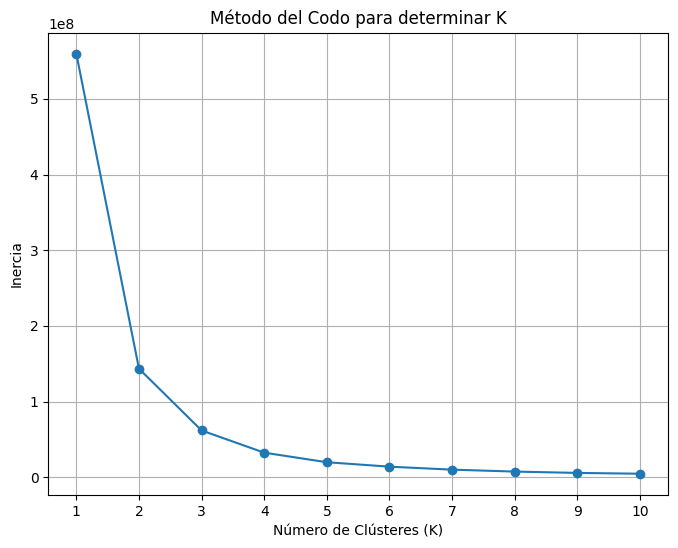

In [16]:
# Evaluar diferentes valores de K
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_transformed)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Número de Clústeres (K)")
plt.ylabel("Inercia")
plt.title("Método del Codo para determinar K")
plt.xticks(K_range)
plt.grid(True)
plt.show()


K=4 parece ser una buena opción

### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

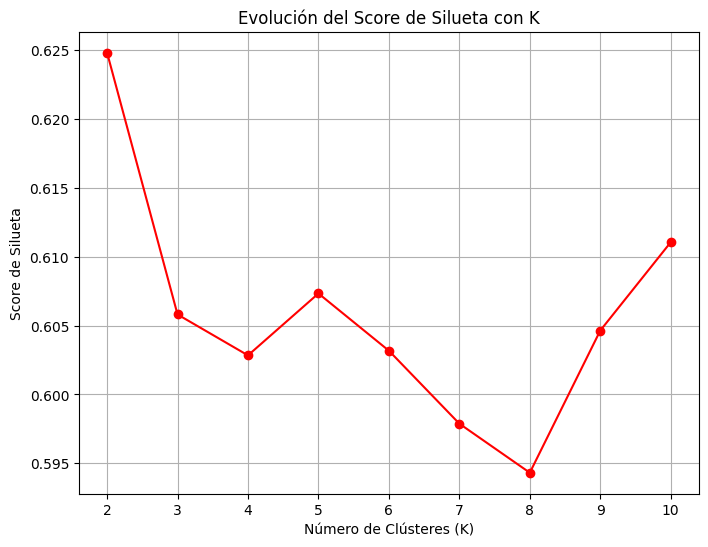

In [18]:
# Evaluar el score de silueta para diferentes valores de K
silhouette_scores = []

for k in K_range[1:]:  # Empezamos desde 2 porque K=1 no tiene sentido en silueta
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_transformed)
    score = silhouette_score(X_transformed, labels)
    silhouette_scores.append(score)

# Graficar el score de silueta
plt.figure(figsize=(8, 6))
plt.plot(K_range[1:], silhouette_scores, marker="o", linestyle="-", color="r")
plt.xlabel("Número de Clústeres (K)")
plt.ylabel("Score de Silueta")
plt.title("Evolución del Score de Silueta con K")
plt.xticks(K_range[1:])
plt.grid(True)
plt.show()


### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

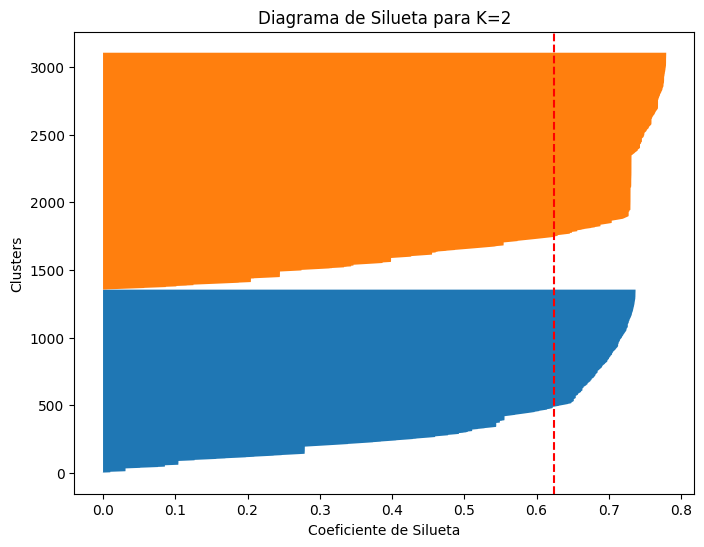

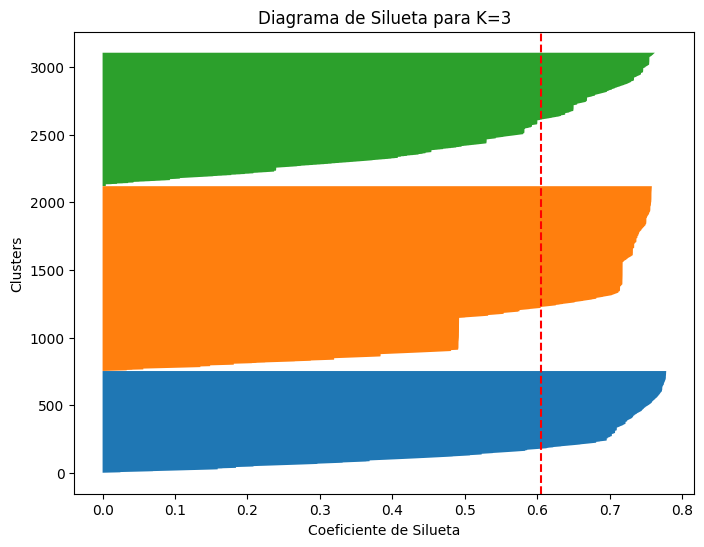

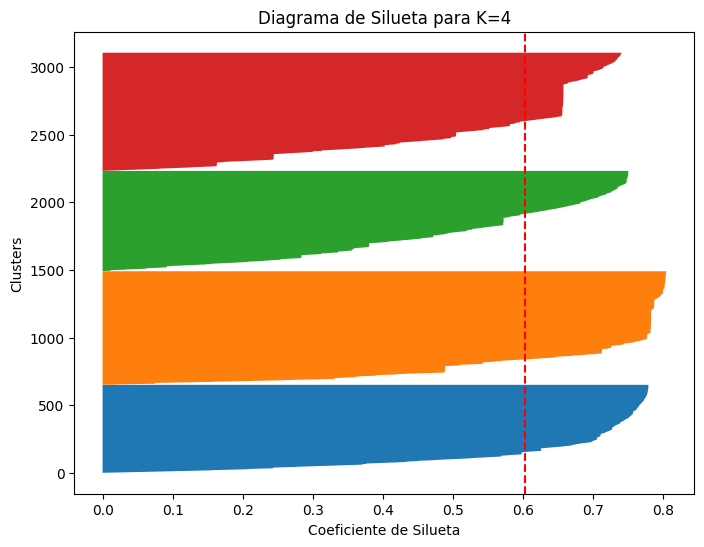

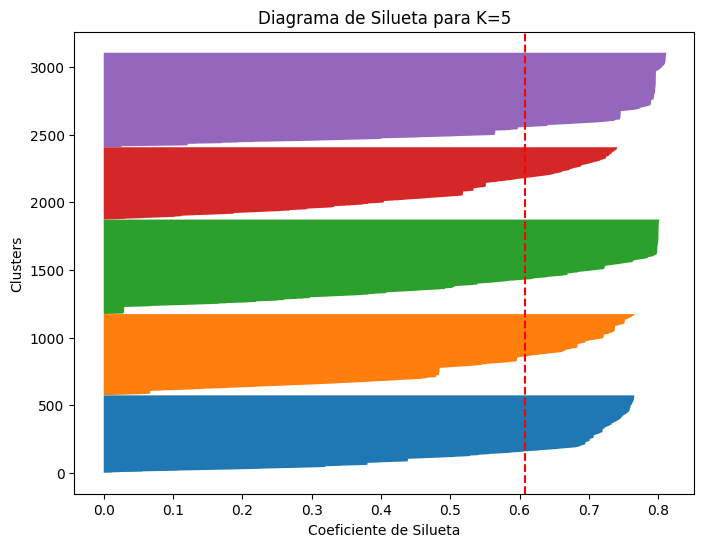

In [21]:
# Función para graficar el diagrama de silueta
def plot_silhouette_diagram(X, n_clusters):
    fig, ax = plt.subplots(figsize=(8, 6))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)

    silhouette_vals = silhouette_samples(X, cluster_labels)
    y_lower, y_upper = 0, 0

    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals)
        y_lower = y_upper

    ax.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
    ax.set_xlabel("Coeficiente de Silueta")
    ax.set_ylabel("Clusters")
    ax.set_title(f"Diagrama de Silueta para K={n_clusters}")

    plt.show()

# Generar diagramas de silueta para K=2,3,4,5
for k in [2, 3, 4, 5]:
    plot_silhouette_diagram(X_transformed, k)


### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

In [24]:
best_k = 5

# Entrenar modelo K-Means con el mejor K
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
X["cluster"] = kmeans.fit_predict(X_transformed.drop(columns=["cluster_alt"], errors="ignore"))


### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

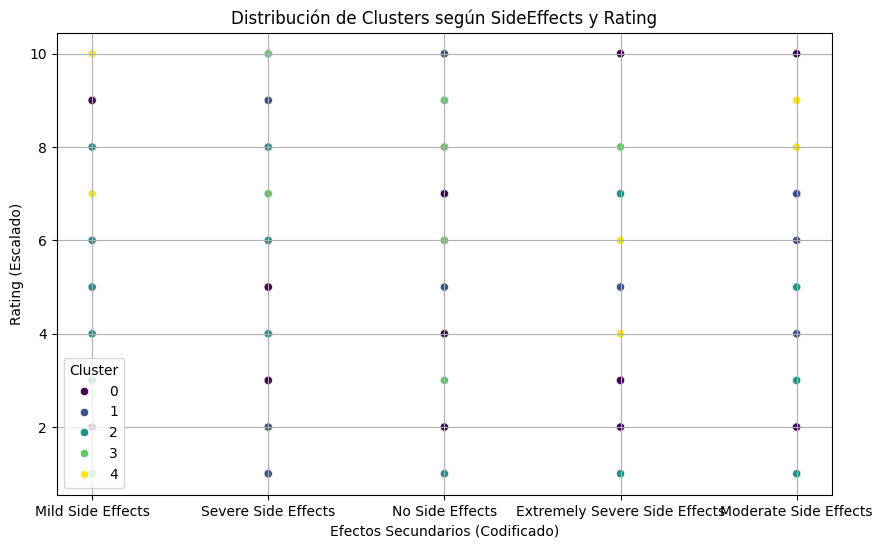

In [29]:
# Analizar estadísticas descriptivas por clúster
cluster_summary = X.groupby("cluster").describe()

# Visualizar los clusters con un pairplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X, x="sideEffects", y="rating", hue="cluster", palette="viridis")
plt.xlabel("Efectos Secundarios (Codificado)")
plt.ylabel("Rating (Escalado)")
plt.title("Distribución de Clusters según SideEffects y Rating")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.

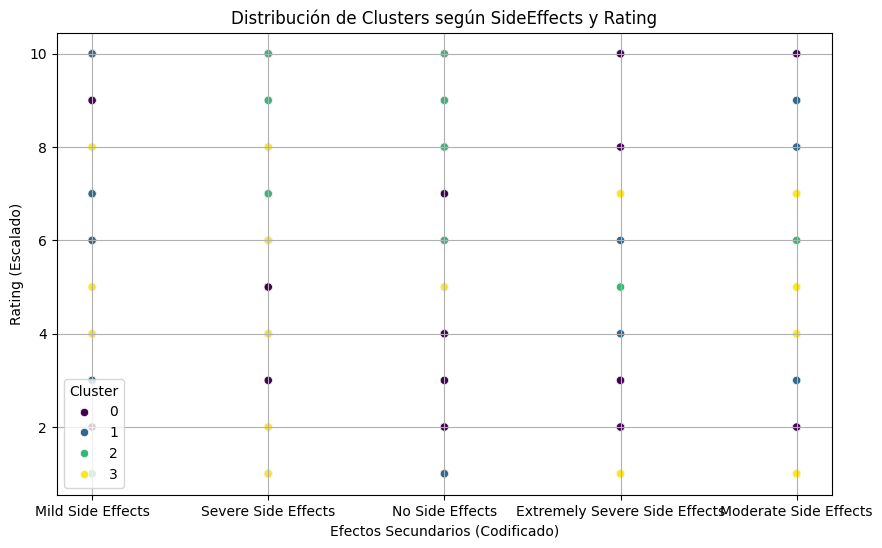

In [34]:
k4 = 4

# Entrenar modelo K-Means con el mejor K
kmeans = KMeans(n_clusters=k4, random_state=42, n_init=10)
X["cluster"] = kmeans.fit_predict(X_transformed.drop(columns=["cluster_alt"], errors="ignore"))

# Analizar estadísticas descriptivas por clúster
cluster_summary = X.groupby("cluster").describe()

# Visualizar los clusters con un pairplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X, x="sideEffects", y="rating", hue="cluster", palette="viridis")
plt.xlabel("Efectos Secundarios (Codificado)")
plt.ylabel("Rating (Escalado)")
plt.title("Distribución de Clusters según SideEffects y Rating")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()